## Comparaison des modèles

#### Pistes à explorer :

- Algorithme en deux étapes : classification puis différence de gaussienne sur les positifs pour améliorer notre taux de précision. Eventuellement essayer d'aller jusqu'à la localisation.
- Evaluer l'impact du contexte en testant sur des imagettes plus grosses (80x80). Attention, l'augmentation de données est moins efficace avec des imagettes plus grosses. En effet on découpe corse_train_1 en carrés plus gros. Si c'est pour redécouper derrière, faible intérêt.
- Tester un modèle avec batch normalization.
- Augmentation du jeu de données à poursuivre.
- Evaluer l'effet de l'ajout d'une couche de convolution sur le modèle baseline.
- Tester à nouveau le transfer learning avec VGG16 et moins de couches convolutives.

### Chargement des modèles

On sélectionne les modèles les plus interessants parmi les derniers runs.

In [1]:
import sys
sys.path.insert(0, '/mnt/data/')
%cd /mnt/data/CU02_classification/

import os
logdir = 'models/hypotheses/'
dirs = os.listdir(logdir)
dirs

/mnt/data/CU02_classification


['run-20171010-1627-more_filters_323232',
 'run-20171010-1644-smaller_inputs',
 'run-20171010-1637-downsampling_fond',
 'run-20171010-1412-batchNorm_rotations+flip+decentrage_161616_444_48x48x1_1vs9']

In [2]:
selec = [dirs[i] for i in [0,1,2,3]]
selec

['run-20171010-1627-more_filters_323232',
 'run-20171010-1644-smaller_inputs',
 'run-20171010-1637-downsampling_fond',
 'run-20171010-1412-batchNorm_rotations+flip+decentrage_161616_444_48x48x1_1vs9']

Puis on crée les générateurs d'images associés à chaque modèle. Les données de test sont les imagettes issues de l'extrait "test" de la Corse.

In [3]:
import os
from keras.models import load_model
from pydrm.roim.keras_image_custom2 import ImageDataGenerator
from pydrm.keras_metrics_custom import recall, precision, f_beta

import keras.metrics
keras.metrics.precision = precision
keras.metrics.recall = recall
keras.metrics.f_beta = f_beta

flow_params = {
    'directory' : "data/snapshots_48x48x1/03_48X48X1_2C_PNG_CORSE_TEST/",
    'batch_size' : 32,
    'class_mode' : 'binary',
    'shuffle' : False,
    'color_mode' : 'grayscale'
}

models = []
for path in selec:
    
    model = load_model("{}/{}/checkpt_loss.h5".format(logdir, path))
    input_shapes = model.layers[0].get_config()['batch_input_shape']
    
    print('Loading generator for model {}...'.format(path))
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(target_size = input_shapes[1:3], **flow_params)
    
    models.append({
        'name' : path,
        'model' : model,    
        'input_shapes' : input_shapes,
        'generator' : gen
    })

Using TensorFlow backend.


Loading generator for model run-20171010-1627-more_filters_323232...
Found 47817 images belonging to 2 classes.
Loading generator for model run-20171010-1644-smaller_inputs...
Found 47817 images belonging to 2 classes.
Loading generator for model run-20171010-1637-downsampling_fond...
Found 47817 images belonging to 2 classes.
Loading generator for model run-20171010-1412-batchNorm_rotations+flip+decentrage_161616_444_48x48x1_1vs9...
Found 47817 images belonging to 2 classes.


## Prédictions des modèles

Afin de comparer au mieux les modèles, on calcule les prédictions de chacun sur le jeu de validation. Chaque modèle prédit un vecteur de probabilités $(p_1, \ldots,p_n)$ où $p_i = \mathbb{P}(X_i = 1)$. La prédiction finale du modèle est ensuite déterminée par le biais d'une règle $1\{p_i>t\}$ où $t$ est un seuil à déterminer. On choisit le $t$ qui correspond au niveau de rappel demandé par le métier. Le couple (précision, rappel) obtenu avec ce seuil $t$ sert de base pour la comparaison des modèles. 

On commence par calculer les prédictions pour chaque modèle:

In [4]:
steps_val = models[0]['generator'].samples // models[0]['generator'].batch_size + 1
y_true = models[0]['generator'].classes[:steps_val * models[0]['generator'].batch_size]
print('{} images ignorées'.format(models[0]['generator'].samples - len(y_true)))

y_scores = []
for model in models:
    print('Predictions for model {}...'.format(model['name']))
    y_prob = model['model'].predict_generator(model['generator'], steps = steps_val)
    y_scores.append(y_prob)

names = [m['name'] for m in models]

0 images ignorées
Predictions for model run-20171010-1627-more_filters_323232...
Predictions for model run-20171010-1644-smaller_inputs...
Predictions for model run-20171010-1637-downsampling_fond...
Predictions for model run-20171010-1412-batchNorm_rotations+flip+decentrage_161616_444_48x48x1_1vs9...


In [5]:
import pydrm.model_evaluation as me

import imp
me = imp.reload(me)

t = 0.5
print("threshold : {}".format(t))
metrics = me.get_metrics(y_true, y_scores, threshold = t, labels = names, df = 'pandas')
metrics

threshold : 0.5


,accuracy,f1,precision,recall
run-20171010-1627-more_filters_323232,0.937993,0.348208,0.260612,0.524503
run-20171010-1644-smaller_inputs,0.873058,0.248018,0.152545,0.662914
run-20171010-1637-downsampling_fond,0.961018,0.343199,0.366717,0.322517
run-20171010-1412-batchNorm_rotations+flip+decentrage_161616_444_48x48x1_1vs9,0.929209,0.370233,0.257439,0.658940


In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from itertools import compress

best = metrics.loc[metrics['f1'] == max(metrics['f1'])]
ix_best = [m['name'] == best.index.values[0] for m in models]
y_scores_best = list(compress(y_scores, ix_best))[0]
y_pred_best = (y_scores_best > t)
cm = confusion_matrix(y_true, y_pred_best)
cm_pretty = pd.DataFrame(cm, columns = ['predicted : 0', 'predicted : 1'], index = ['0', '1'])
print('Matrice de confusion au seuil t = {}'.format(t))
cm_pretty

Matrice de confusion au seuil t = 0.5


,predicted : 0,predicted : 1
0,43437,2870
1,515,995


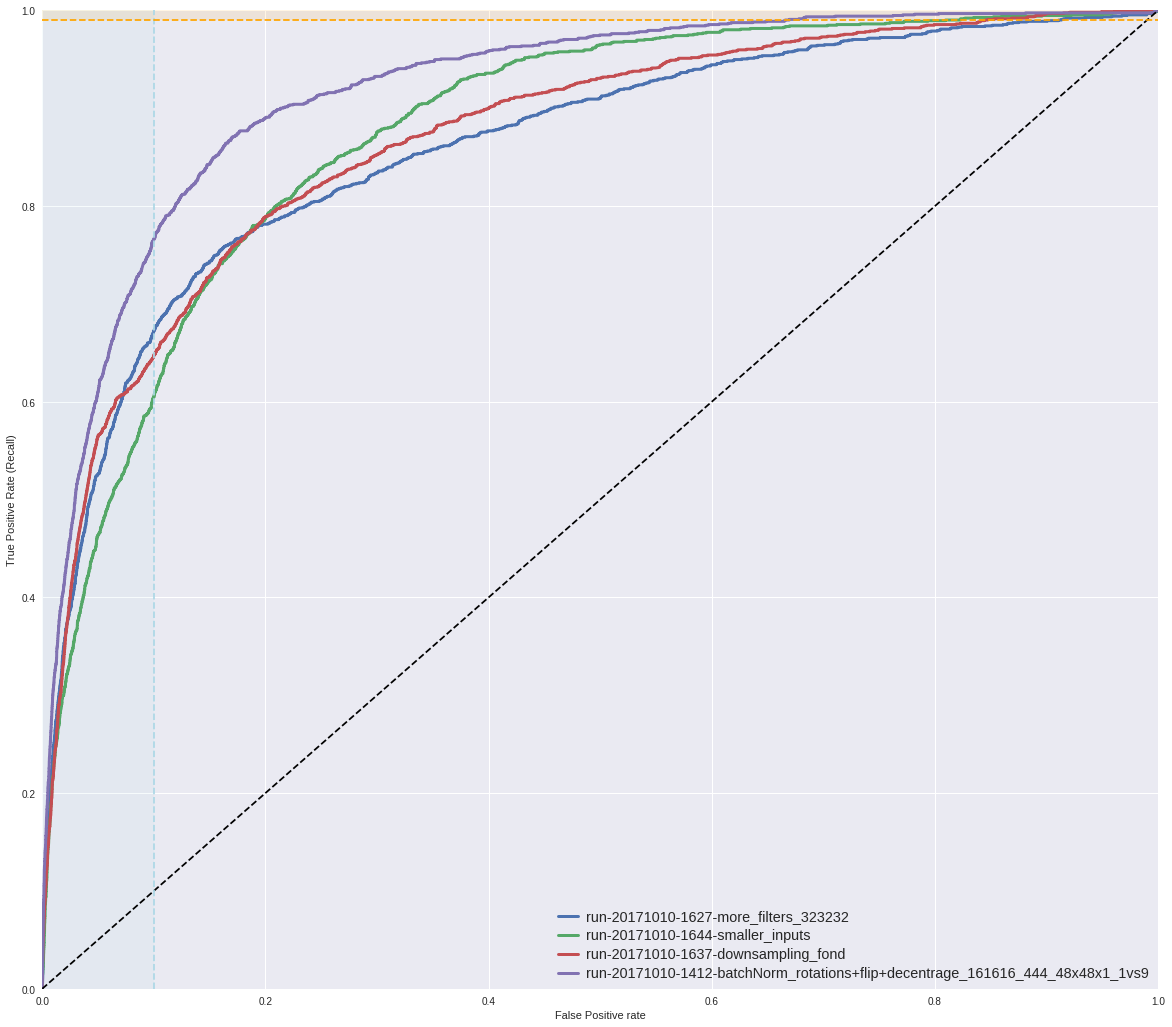

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

from pydrm.model_evaluation import plot_roc_curves
roc = plot_roc_curves(y_true, y_scores, labels = names)

plt.axvline(0.1, color = 'lightblue', linestyle = '--')
plt.axvspan(0, 0.1, facecolor = 'lightblue', alpha = 0.1)
plt.axhline(0.99, color = 'orange', linestyle = '--')
plt.axhspan(0.99, 1, facecolor = 'orange', alpha = 0.1)

## Arbitrage précision / rappel : sélection du meilleur seuil $\alpha$

Puis on trace les courbes ROC pour chaque modèle. On s'aperçoit que le niveau de performance demandé par le métier (recall > 99% et taux de faux positif < 10%) est hors d'atteinte pour le moment !!!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

from pydrm.model_evaluation import plot_roc_curves
roc = plot_roc_curves(y_true, y_scores, labels = [m['name'] for m in models])

plt.axvline(0.1, color = 'lightblue', linestyle = '--')
plt.axvspan(0, 0.1, facecolor = 'lightblue', alpha = 0.1)
plt.axhline(0.99, color = 'orange', linestyle = '--')
plt.axhspan(0.99, 1, facecolor = 'orange', alpha = 0.1)

#### Impact de l'augmentation du train

Les modèles entrainés sur le petit corpus performent beaucoup moins bien sur notre nouveau jeu de test. L'arbitrage précision / rappel est beaucoup moins favorable: augmenter légèrement l'exigence en rappel (+1 point) nécessite d'admettre un taux de faux positif beaucoup plus élevé (+10 points). Le taux de croissance de la courbe ROC décroit très vite vers 0 (admettre plus de faux négatifs n'améliore pas le taux de faux positifs); jusqu'au point d'inflexion, moment à partir duquel on est tellement tolérant sur le taux de faux positifs qu'on trouve les vrais positifs mécaniquement.

#### Impact de l'architecture

Au seuil $t$, le modèle (16/16/16) x (4/4/4) est meilleur que le modèle (32/32/32/64) x (3/3/3/3). Le modèle à 4 couches est meilleur pour $t>0.6$, moins bon sinon. Intuitivement, la couche supplémentaire permet au modèle de sur-apprendre plus rapidement. Le modèle en entonnoir (32/16/16) x (6/3/3) est beaucoup plus long à entrainer et a des résultats très instables sur le jeu de validation.

On sélectionne le meilleur modèle et on calcule le seuil $t$ tel que le taux de rappel soit au moins égal au minimum demandé par le métier.

In [ ]:
best_model = 3
min_recall = 0.5

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores[best_model])

fig, ax = plt.subplots(figsize = (10, 10))
plt.plot(thresholds, precisions[:-1], linewidth = 3, label = 'Precision')
plt.plot(thresholds, recalls[:-1], linewidth = 3, label = 'Recall')
plt.xlabel('Thresholds')
legend = plt.legend(loc = 'upper right', shadow = True)
for label in legend.get_texts():
    label.set_fontsize('large')

plt.axvline(x = thresholds[recalls[:-1] >= min_recall][-1], color = 'darkred', linestyle = '--')
    
print ('Taux de rappel sélectionné : {}'.format(recalls[recalls >= min_recall][-1]))
print('Précision maximale obtenue : {}'.format(precisions[recalls >= min_recall][-1]))
print('Niveau de seuil correspondant : {}'.format(thresholds[recalls[:-1] >= min_recall][-1]))

t = thresholds[recalls[:-1] >= min_recall][-1]

Puis on calcule les statistiques suivantes pour tous les modèles : accuracy, precision, recall, f1_score

In [ ]:
from pydrm.model_evaluation import plot_precision_recall_vs_threshold
plot_precision_recall_vs_threshold(y_true, y_scores, 
                                   threshold = t, 
                                   best = best_model, 
                                   labels = [m['name'] for m in models], 
                                   ncols = 2)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

metrics = []
for y_score in y_scores:
    
    y_pred = (y_score >= t)
    metrics.append({
        'accuracy': accuracy_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
    })

import pandas as pd
metrics = pd.DataFrame(metrics, index = [m['name'] for m in models])
metrics

On s'aperçoit que la "pertinence (accuracy) n'est pas une mesure pertinente dans notre cas. Face à un problème de détection de phénomène rare (classe fond beaucoup plus fréquente), une approche simpliste qui répond toujours 'non' obientendrait déjà 90% sur cette métrique !!!


## Meilleur modèle

On retient le modèle qui présente le meilleur score $f_1$ au seuil $t$. 

In [ ]:
from itertools import compress

best = metrics.loc[metrics['f1'] == max(metrics['f1'])]
ix_best = [m['name'] == best.index.values[0] for m in models]
y_scores_best = list(compress(y_scores, ix_best))[0]

print('Meilleur modèle au seuil t = {}'.format(t))
best

On calcule la matrice de confusion au seuil $t$ pour ce modèle. On retrouve bien le niveau de rappel demandé en faisant le rapport des valeurs de la deuxième ligne.

In [ ]:
y_pred_best = (y_scores_best > t)
cm = confusion_matrix(y_true, y_pred_best)
cm_pretty = pd.DataFrame(cm, columns = ['predicted : 0', 'predicted : 1'], index = ['0', '1'])

print('Matrice de confusion au seuil t = {}'.format(t))
cm_pretty

On dessine les faux négatifs / faux positifs pour essayer de comprendre quand est-ce que l'algorithme se trompe.

In [ ]:
%matplotlib inline
from skimage import io
import random
import numpy as np
from pydrm.model_evaluation import prediction_parser, plot_gallery

y_pred_parsed = prediction_parser(y_true, y_pred_best)
filenames = models[0]['generator'].filenames
df = pd.DataFrame([np.array(filenames), y_true, y_pred_best, y_pred_parsed], index = ['path', 'true', 'prediction', 'type']).T

selec = df.loc[df['type'] == 'FN']
ix = selec.index[:70]
#ix = random.sample(list(selec.index), 70, )
imgs = [io.imread(models[0]['generator'].directory + f) for f in np.array(filenames)[ix]]
titles = prediction_parser(y_true, y_pred_best)[ix]
plot_gallery(imgs, titles = titles)

In [ ]:
from keras.models import Sequential
moedl = Sequential()
moedl.add?

In [ ]:
1**1

In [ ]:
1**2

In [ ]:
2**2

In [ ]:
4**2

In [ ]:
2*((0.1998*0.4266) / (0.1998 + 0.4266))